<a href="https://colab.research.google.com/github/wvsvenkat/MyoPS2020/blob/main/ValidationUsingStage2PreTrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total cases found: 25
Validation dataset size: 5
Loaded model from /content/drive/MyDrive/MyoPS2020/checkpoints/unet_final.pth


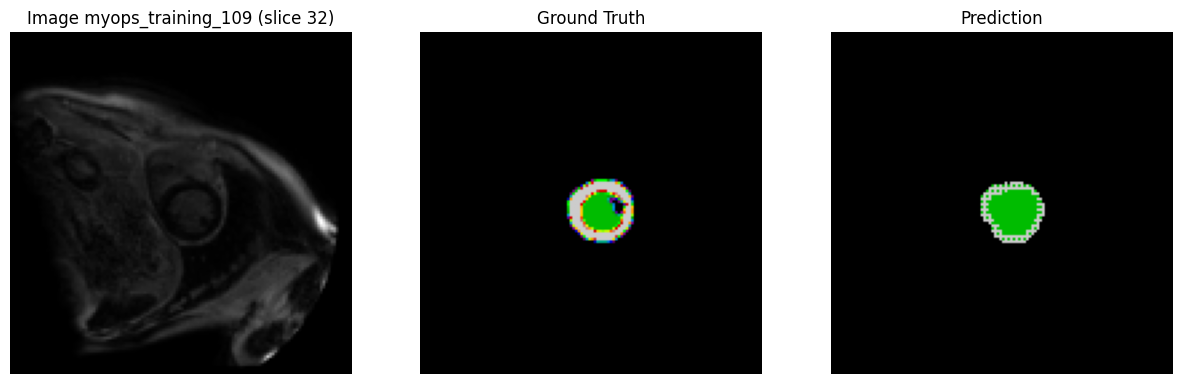

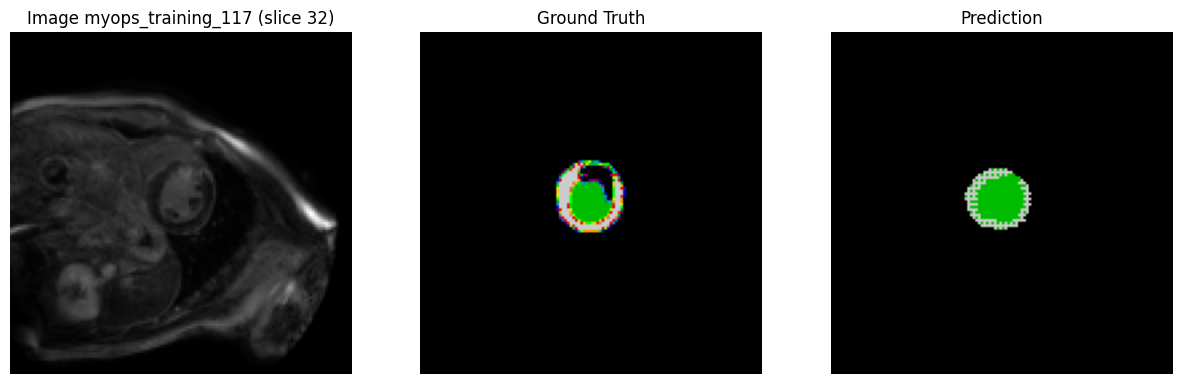

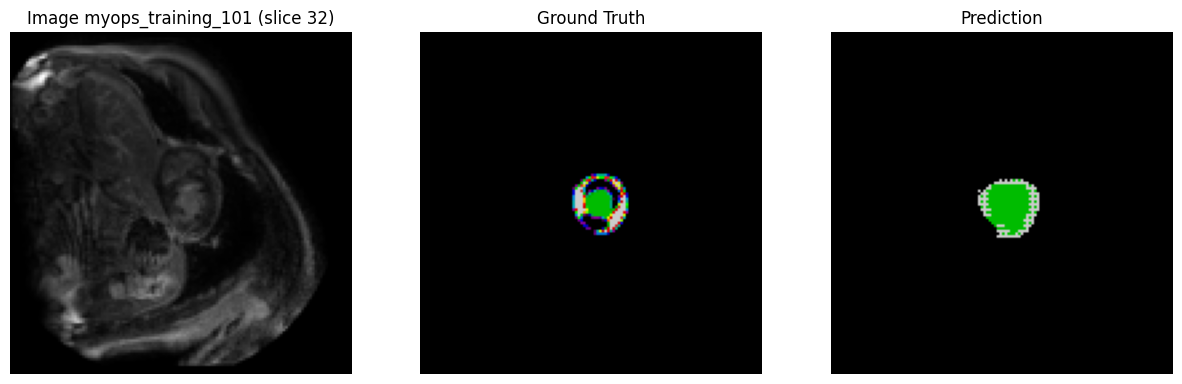

In [8]:
# ============================================
# 📦 Setup & Imports
# ============================================
!pip install monai nibabel pydicom pandas -q
!pip install torch torchvision torchaudio -q

import os, re, zipfile, glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ScaleIntensityd, EnsureTyped,
    Resized, Compose, ConcatItemsd, Transform
)
from monai.data import Dataset
from monai.networks.nets import UNet

# ============================================
# 📁 Mount Google Drive & Extract Data
# ============================================
from google.colab import drive
drive.mount('/content/drive')

train_zip = "/content/drive/MyDrive/MyoPS2020/train25.zip"
gt_zip    = "/content/drive/MyDrive/MyoPS2020/train25_myops_gd.zip"

extract_path = "/content/myops_mm3d"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(train_zip, 'r') as z:
    z.extractall(extract_path + "/train")
with zipfile.ZipFile(gt_zip, 'r') as z:
    z.extractall(extract_path + "/labels")

train_root = os.path.join(extract_path, "train")
label_root = os.path.join(extract_path, "labels")
if len(os.listdir(train_root)) == 1:
    train_root = os.path.join(train_root, os.listdir(train_root)[0])
if len(os.listdir(label_root)) == 1:
    label_root = os.path.join(label_root, os.listdir(label_root)[0])

# ============================================
# 🧬 Group Files by Case & Modality
# ============================================
def list_files(root):
    exts = ("*.nii", "*.nii.gz")
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    return sorted(files)

train_files_all = list_files(train_root)
label_files_all = list_files(label_root)

def modality_of(path):
    name = os.path.basename(path).lower()
    if "_c0" in name: return "bssfp"
    if "_t2" in name: return "t2"
    if "_de" in name: return "lge"
    return None

def case_id_of(path):
    name = os.path.basename(path).lower()
    name = name.replace("_c0", "").replace("_t2", "").replace("_de", "").replace("_gd", "")
    return re.sub(r"\.nii(\.gz)?$", "", name)

cases = {}
for f in train_files_all:
    mod = modality_of(f)
    cid = case_id_of(f)
    if mod:
        cases.setdefault(cid, {})[mod] = f

labels_by_case = {case_id_of(f): f for f in label_files_all}

items = []
for cid, mods in cases.items():
    if all(k in mods for k in ["lge", "t2", "bssfp"]) and cid in labels_by_case:
        items.append({
            "lge": mods["lge"],
            "t2": mods["t2"],
            "bssfp": mods["bssfp"],
            "label": labels_by_case[cid],
            "case_id": cid
        })

print("Total cases found:", len(items))

# ============================================
# 🧼 Label Remapping
# ============================================
class FixedRemapLabels(Transform):
    def __init__(self, mapping):
        self.mapping = mapping
    def __call__(self, data):
        label = data["label"]
        if isinstance(label, np.ndarray):
            label = torch.from_numpy(label)
        label = label.long()
        for orig, target in self.mapping.items():
            label[label == orig] = target
        valid_targets = torch.tensor(list(self.mapping.values()), dtype=label.dtype)
        mask = ~torch.isin(label, valid_targets)
        label[mask] = 0
        data["label"] = label
        return data

label_mapping = {0: 0, 500: 1, 200: 2, 75: 3, 60: 3}
target_size = (128, 128, 64)

base_transforms = Compose([
    LoadImaged(keys=["lge", "t2", "bssfp", "label"]),
    EnsureChannelFirstd(keys=["lge", "t2", "bssfp", "label"]),
    ScaleIntensityd(keys=["lge", "t2", "bssfp"]),
    FixedRemapLabels(label_mapping),
    ConcatItemsd(keys=["lge", "t2", "bssfp"], name="image", dim=0),
    Resized(keys=["image", "label"], spatial_size=target_size),
    EnsureTyped(keys=["image", "label"])
])

# Split into train/val
train_items, val_items = train_test_split(items, test_size=0.2, random_state=42)
val_ds   = Dataset(data=val_items, transform=base_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

print("Validation dataset size:", len(val_ds))

# ============================================
# 🧠 Load Saved Model
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=4,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)

ckpt_path = "/content/drive/MyDrive/MyoPS2020/checkpoints/unet_final.pth"
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"])
model.eval()
print("Loaded model from", ckpt_path)

# ============================================
# 🖼️ Run Validation & Plot
# ============================================
def run_inference_and_plot(val_loader, num_samples=3):
    model.eval()
    count = 0
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            case_id = batch["case_id"][0]

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()[0]
            gt    = labels.cpu().numpy()[0,0]
            img   = images.cpu().numpy()[0,0]

            mid_slice = preds.shape[-1] // 2
            fig, axs = plt.subplots(1,3, figsize=(15,5))
            axs[0].imshow(img[:,:,mid_slice], cmap="gray")
            axs[0].set_title(f"Image {case_id} (slice {mid_slice})")
            axs[1].imshow(gt[:,:,mid_slice], cmap="nipy_spectral")
            axs[1].set_title("Ground Truth")
            axs[2].imshow(preds[:,:,mid_slice], cmap="nipy_spectral")
            axs[2].set_title("Prediction")
            for ax in axs: ax.axis("off")
            plt.show()

            count += 1
            if count >= num_samples:
                break

# Run visualization
run_inference_and_plot(val_loader, num_samples=3)